In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df = pd.read_csv("../results/benchmarks/clustering_benchmarks.csv")

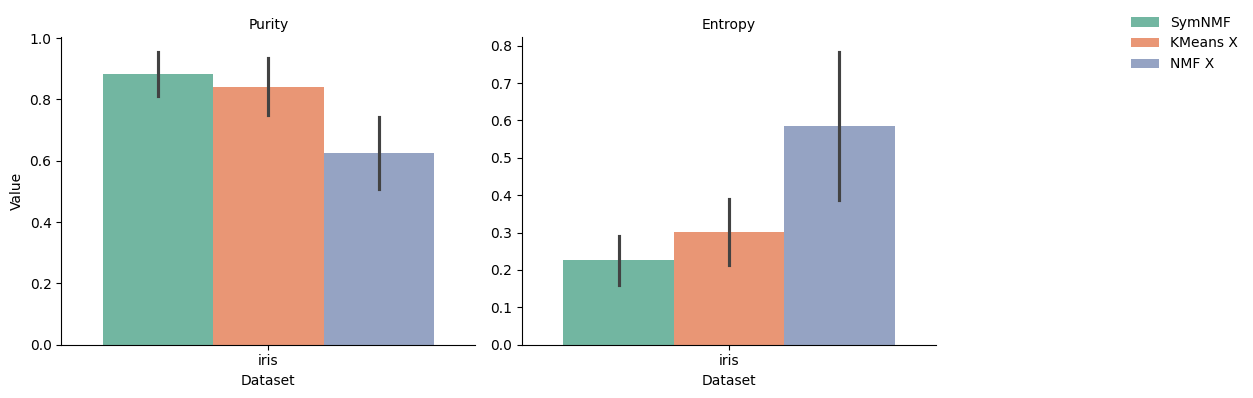

In [23]:
# remove dataset haxby-faces if it exists
# df = df[df["Dataset"] != "haxby-faces"]
# df = df[df["Dataset"] != "diabetes"]

df = df.drop(columns=["Accuracy"])
df["Model"] = df["Model"].replace("SyNMF ADMM", "SymNMF")


# Melt the dataframe to have a long-form dataframe suitable for facetgrid
df_melted = df.melt(
    id_vars=["Dataset", "Model", "Seed"],
    # value_vars=["Purity", "Entropy", "Sparseness"],
    value_vars=["Purity", "Entropy"],
    var_name="Metric",
    value_name="Value",
)


df.groupby(["Dataset", "Model"]).agg({"Purity": ["mean", "std", "max", "min"]})

# Create a FacetGrid for the different metrics
g = sns.FacetGrid(
    df_melted,
    col="Metric",
    sharey=False,
    height=4,
    aspect=1.2,
    col_wrap=2,
    sharex=False,
)
g.map_dataframe(
    sns.barplot, x="Dataset", y="Value", hue="Model", errorbar="sd", palette="Set2"
)

# Adjust the legend and labels
# g.add_legend(bbox_to_anchor=(1.05, 1), loc="upper lefxt")
g.add_legend(bbox_to_anchor=(1.05, 1), loc="upper left")
g.set_axis_labels("Dataset", "Value")
g.set_titles(col_template="{col_name}")

plt.show()
plt.close()

In [19]:
import numpy as np
from srf.benchmarks.clustering import construct_similarity_graph
from srf.datasets import load_dataset
from srf.mixed.admm import ADMM
from srf.models.symmetric import Symmetric
from srf.models.projection import ProjectionKernelNMF
from srf.mixed.cd_updates import update_w
from srf.helpers import map_labels_with_hungarian
from sklearn.metrics import accuracy_score

iris = load_dataset("iris")
x = iris.data
y = iris.targets
rank = len(np.unique(y))

graph = construct_similarity_graph(x, nn=7)


model = ADMM(
    rank=rank,
    max_outer=10,
    w_inner=1000,
    tol=0.0,
    verbose=True,
    rho=1.0,
    init="random_sqrt",
    random_state=2,
)
w = model.fit_w(graph)


y_hat = np.argmax(w, axis=1)

y_hat = map_labels_with_hungarian(y, y_hat)

accuracy_score(y, y_hat)

0.9066666666666666